## Standard GAN Implementation

Based on the paper <i>Generative Adversarial Nets</i>, with the implementation inspired by the paper <i>Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks</i>, but varied as described [here](https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0). Using the MNIST dataset for the general generative task, and for using the GAN as an unsupervised feature extractor. Interesting article about the GAN training process [here](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628). There is an important nuance in that when the generator is trained, you want to label the output from the generator as real so that the discriminator assigns a larger error to it (for updating the model parameters), as described [here](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/).

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input,Dense,Reshape,Dropout,BatchNormalization,Activation,UpSampling2D
from tensorflow.keras.layers import BatchNormalization,Conv2D,LeakyReLU,Flatten,Conv2DTranspose
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

tf.keras.backend.set_floatx('float32')
import warnings
warnings.filterwarnings('ignore')
import sys
tf.compat.v1.enable_eager_execution()

### Data Cleaning

In [2]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_train = x_train[y_train <= 3] # using numbers 0,..,3
y_train = y_train[y_train <= 3]
x_train.shape,y_train.shape

((24754, 28, 28), (24754,))

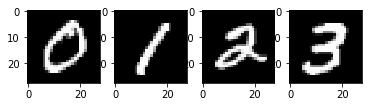

In [3]:
plt.subplot(1,4,1)
plt.imshow(x_train[0],cmap="gray")
plt.subplot(1,4,2)
plt.imshow(x_train[1],cmap="gray")
plt.subplot(1,4,3)
plt.imshow(x_train[2],cmap="gray")
plt.subplot(1,4,4)
plt.imshow(x_train[4],cmap="gray")
plt.show()

In [4]:
x_train = x_train/255 # scaling the images

### Model Implementation

In [5]:
def get_generator():
    """ generator implementation
    """
    model = Sequential()
    model.add(Input(shape=100))
    model.add(Dense(7*7*256))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(Reshape((7,7,256)))
    model.add(Dropout(0.4))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(filters=128,kernel_size=5,strides=1,padding='same',activation=None))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(filters=64,kernel_size=5,strides=1,padding='same',activation=None))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(Conv2DTranspose(filters=32,kernel_size=5,strides=1,padding='same',activation=None))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(Conv2DTranspose(filters=1,kernel_size=5,strides=1,padding='same',activation=None))
    model.add(Activation('sigmoid'))
    return model

In [6]:
def get_discriminator():
    """ discriminator implementation
    """
    model = Sequential()
    model.add(Input(shape=(28,28,1)))
    model.add(Conv2D(filters=64,kernel_size=5,strides=2,padding='same',activation=None))
    #model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(filters=128,kernel_size=5,strides=2,padding='same',activation=None))
    #model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(filters=256,kernel_size=5,strides=2,padding='same',activation=None))
    #model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(filters=512,kernel_size=5,strides=1,padding='same',activation=None))
    #model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1,activation=None))
    model.add(Activation('sigmoid'))
    return model

In [7]:
def discriminator_model(discriminator):
    optimizer = Adam(lr=0.0002)
    model = Sequential()
    model.add(discriminator)
    model.compile(loss='binary_crossentropy',optimizer=optimizer)
    return model

In [8]:
def adversarial_model(generator,discriminator):
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy',optimizer=optimizer)
    return model

### Model Training

The noise prior z~N(0,1)

In [9]:
d = get_discriminator()
generator = get_generator()
discriminator = discriminator_model(d)
adversarial = adversarial_model(generator,d)
x_train = np.expand_dims(x_train,axis=-1)
x_train = x_train[:24700]
x_train.shape

(24700, 28, 28, 1)

In [29]:
batch_size=50
for _ in range(10): # number of epochs
    for i in range(0,len(x_train)-batch_size,batch_size): # looping through batches rather than sampling
        x_data = x_train[i:i+batch_size]
        z = np.random.normal(0.0,1.0,size=(batch_size,100))
        x_gen = generator.predict(z)
        x = np.concatenate((x_data,x_gen))
        y = np.vstack([np.ones((batch_size,1)),np.zeros((batch_size,1))])
        d_loss = discriminator.train_on_batch(x,y)
        
        y = np.ones([batch_size, 1])
        z = np.random.normal(0.0,1.0,size=(batch_size,100))
        a_loss = adversarial.train_on_batch(z,y)
        
        print("gen. loss:{}; disc. loss:{}".format(a_loss,d_loss))
        noise = np.random.normal(0.0,1.0,size=(1,100))
        gen = generator.predict(noise)*255
        gen.shape = (28,28)
        plt.imshow(gen,cmap="gray")
        plt.show()

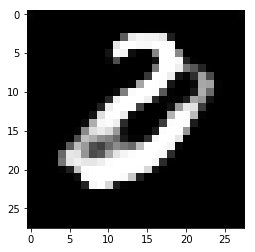

In [30]:
noise = np.random.normal(0.0,1.0,size=(1,100))
gen = generator.predict(noise)*255
gen.shape = (28,28)
plt.imshow(gen,cmap="gray")
plt.show()

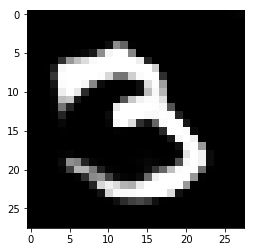

In [31]:
noise = np.random.normal(0.0,1.0,size=(1,100))
gen = generator.predict(noise)*255
gen.shape = (28,28)
plt.imshow(gen,cmap="gray")
plt.show()

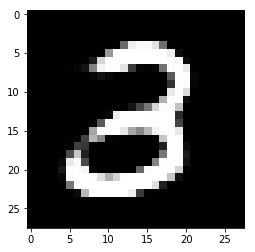

In [33]:
noise = np.random.normal(0.0,1.0,size=(1,100))
gen = generator.predict(noise)*255
gen.shape = (28,28)
plt.imshow(gen,cmap="gray")
plt.show()

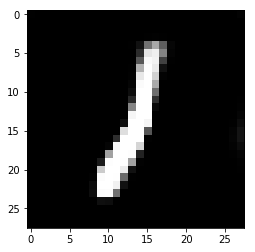

In [36]:
noise = np.random.normal(0.0,1.0,size=(1,100))
gen = generator.predict(noise)*255
gen.shape = (28,28)
plt.imshow(gen,cmap="gray")
plt.show()

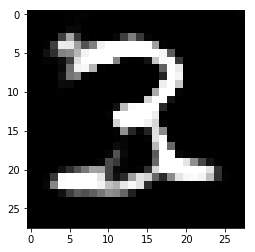

In [37]:
noise = np.random.normal(0.0,1.0,size=(1,100))
gen = generator.predict(noise)*255
gen.shape = (28,28)
plt.imshow(gen,cmap="gray")
plt.show()

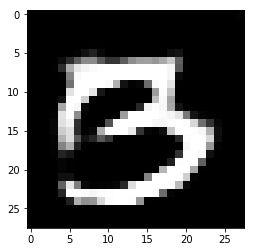

In [38]:
noise = np.random.normal(0.0,1.0,size=(1,100))
gen = generator.predict(noise)*255
gen.shape = (28,28)
plt.imshow(gen,cmap="gray")
plt.show()

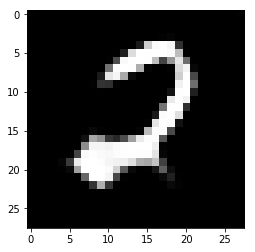

In [39]:
noise = np.random.normal(0.0,1.0,size=(1,100))
gen = generator.predict(noise)*255
gen.shape = (28,28)
plt.imshow(gen,cmap="gray")
plt.show()

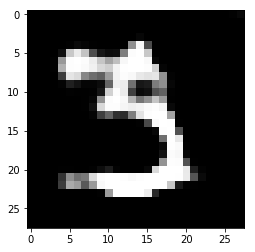

In [13]:
noise = np.random.normal(0.0,1.0,size=(1,100))
gen = generator.predict(noise)*255
gen.shape = (28,28)
plt.imshow(gen,cmap="gray")
plt.show()

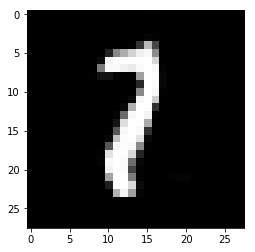

In [15]:
noise = np.random.normal(0.0,1.0,size=(1,100))
gen = generator.predict(noise)*255
gen.shape = (28,28)
plt.imshow(gen,cmap="gray")
plt.show()

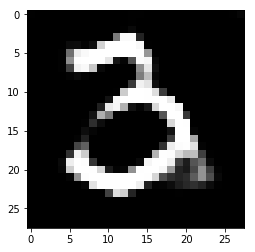

In [16]:
noise = np.random.normal(0.0,1.0,size=(1,100))
gen = generator.predict(noise)*255
gen.shape = (28,28)
plt.imshow(gen,cmap="gray")
plt.show()